In [2]:
import os
os.chdir(r'C:\Users\Hp\Desktop\ml labs')

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [4]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [5]:
def CNN():
    input_data = Input(shape=(time_steps, num_features))
    x1 = Conv1D(16, 2, activation="relu")(input_data)
    x2 = Conv1D(16, 2, activation="relu")(x1)
    flatten = Flatten()(x2)
    output_data = Dense(1)(flatten)
    model = Model(input_data, output_data)
    return model

In [6]:
model1 = CNN()
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 21)]          0         
                                                                 
 conv1d (Conv1D)             (None, 23, 16)            688       
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 16)            528       
                                                                 
 flatten (Flatten)           (None, 352)               0         
                                                                 
 dense (Dense)               (None, 1)                 353       
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________


In [7]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


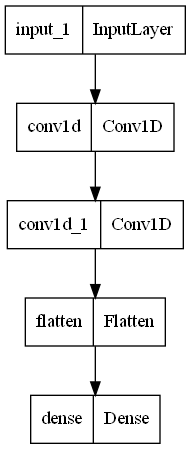

In [8]:
tensorflow.keras.utils.plot_model(model1 )

In [9]:
checkpoints = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 8 checkpoints\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'C:\Users\Hp\Desktop\ml labs'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [10]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [11]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =CNN()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [12]:
import os
path_dataset =r'C:\Users\Hp\Desktop\ml labs\AEP hourly'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

((84907, 21), (24259, 21), (12130, 21))

In [13]:
time_steps=24
num_features=21

In [14]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.9434225559234619 sec


In [15]:
epochs = 60
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/60
2653/2653 [==============================] - ETA: 0s - loss: 0.0526 - mae: 0.0526 - mape: 2150.8345
Epoch 1: val_loss improved from inf to 0.02791, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 8 checkpoints\E1-cp-0001-loss0.03.h5
2653/2653 [==============================] - 12s 4ms/step - loss: 0.0526 - mae: 0.0526 - mape: 2150.8345 - val_loss: 0.0279 - val_mae: 0.0279 - val_mape: 10.6436
Epoch 2/60
2639/2653 [============================>.] - ETA: 0s - loss: 0.0245 - mae: 0.0245 - mape: 593.9954
Epoch 2: val_loss improved from 0.02791 to 0.01996, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 8 checkpoints\E1-cp-0002-loss0.02.h5
2653/2653 [==============================] - 11s 4ms/step - loss: 0.0245 - mae: 0.0245 - mape: 590.9836 - val_loss: 0.0200 - val_mae: 0.0200 - val_mape: 7.4854
Epoch 3/60
2639/2653 [============================>.] - ETA: 0s - loss: 0.0193 - mae: 0.0193 - mape: 691.6072
Epoch 3: val_loss improved from 0.01996 to 0.01745, savin

Epoch 24/60
2650/2653 [============================>.] - ETA: 0s - loss: 0.0105 - mae: 0.0105 - mape: 932.6497
Epoch 24: val_loss improved from 0.00940 to 0.00926, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 8 checkpoints\E1-cp-0024-loss0.01.h5
2653/2653 [==============================] - 14s 5ms/step - loss: 0.0105 - mae: 0.0105 - mape: 931.7511 - val_loss: 0.0093 - val_mae: 0.0093 - val_mape: 5.1778
Epoch 25/60
2647/2653 [============================>.] - ETA: 0s - loss: 0.0103 - mae: 0.0103 - mape: 960.3295
Epoch 25: val_loss did not improve from 0.00926
2653/2653 [==============================] - 11s 4ms/step - loss: 0.0103 - mae: 0.0103 - mape: 958.3218 - val_loss: 0.0094 - val_mae: 0.0094 - val_mape: 5.1863
Epoch 26/60
2649/2653 [============================>.] - ETA: 0s - loss: 0.0104 - mae: 0.0104 - mape: 941.0787
Epoch 26: val_loss did not improve from 0.00926
2653/2653 [==============================] - 11s 4ms/step - loss: 0.0104 - mae: 0.0104 - mape: 939.8178

2653/2653 [==============================] - 11s 4ms/step - loss: 0.0098 - mae: 0.0098 - mape: 787.7706 - val_loss: 0.0097 - val_mae: 0.0097 - val_mape: 4.8212
Epoch 49/60
2639/2653 [============================>.] - ETA: 0s - loss: 0.0099 - mae: 0.0099 - mape: 933.7003
Epoch 49: val_loss did not improve from 0.00871
2653/2653 [==============================] - 11s 4ms/step - loss: 0.0099 - mae: 0.0099 - mape: 928.9384 - val_loss: 0.0097 - val_mae: 0.0097 - val_mape: 5.0731
Epoch 50/60
2649/2653 [============================>.] - ETA: 0s - loss: 0.0098 - mae: 0.0098 - mape: 851.9092
Epoch 50: val_loss did not improve from 0.00871
2653/2653 [==============================] - 12s 4ms/step - loss: 0.0098 - mae: 0.0098 - mape: 850.7680 - val_loss: 0.0106 - val_mae: 0.0106 - val_mape: 5.6069
Epoch 51/60
2645/2653 [============================>.] - ETA: 0s - loss: 0.0098 - mae: 0.0098 - mape: 814.8913
Epoch 51: val_loss did not improve from 0.00871
2653/2653 [==============================] 

In [24]:

model = load_model(r'C:\Users\Hp\Desktop\ml labs\last labs\lab 8 checkpoints\E1-cp-0049-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 135.91
Median Absolute Error (MedAE): 108.92
Mean Squared Error (MSE): 32336.48
Root Mean Squared Error (RMSE): 179.82
Mean Absolute Percentage Error (MAPE): 0.87 %
Median Absolute Percentage Error (MDAPE): 0.69 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [25]:
checkpoints = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 8 checkpoints\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'C:\Users\Hp\Desktop\ml labs\last labs\lab 8 checkpoints\E1-cp-0049-loss0.01.h5'
start_epoch= 50

In [26]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading C:\Users\Hp\Desktop\ml labs\last labs\lab 8 checkpoints\E1-cp-0049-loss0.01.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [1]:
epochs = 20
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

NameError: name 'model' is not defined

In [19]:

model = load_model(r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab8\E2-cp-0008-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 103.3
Median Absolute Error (MedAE): 82.18
Mean Squared Error (MSE): 18772.44
Root Mean Squared Error (RMSE): 137.01
Mean Absolute Percentage Error (MAPE): 0.71 %
Median Absolute Percentage Error (MDAPE): 0.57 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


# lab report 

## Lab 1